In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import glob

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing the data

In [15]:
data_dir = r'/kaggle/input/dataset/dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 

num_file = 1100 
all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

    
# Image dimension
im_width = 230
im_height = 230 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.uint8)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(4000,im_width, im_height, im_channel), dtype=np.uint8)
X_val = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.uint8)
X_test = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.uint8)

y_train = np.empty(4000)
y_val = np.empty(200)
y_test = np.empty(200) 

for i, cls in enumerate(classes): 
    X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
    X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]
    
    y_test[50*i:50*(i+1)] = i
    y_val[50*i:50*(i+1)] = i
    y_train[1000*i:1000*(i+1)] = i
    
del Y 
del X

# Extract features 
#Shuffle training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

#Subtract out the mean image 
#first: compute the mean image
mean_image = np.mean(X_train, axis=0) #axis=0. stack horizontally
#Second subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

#Third append the bias dimension using linear algebra trick
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
X_tiny = np.hstack([X_tiny, np.ones((X_tiny.shape[0], 1))])

print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 158700) | y_train shape: (4000,)
X_test shape (200, 158700) | y_test shape: (200,)
X_val shape (200, 158700) | y_val shape: (200,)
X_dev shape (500, 158700) | y_dev shape: (500,)
X_tiny shape (10, 158700) | y_tiny shape: (10,)
=====STACK BIAS term=====
X_train shape (4000, 158701)
X_test shape (200, 158701)
X_val shape (200, 158701)
X_dev shape (500, 158701)
X_tiny shape (10, 158701)


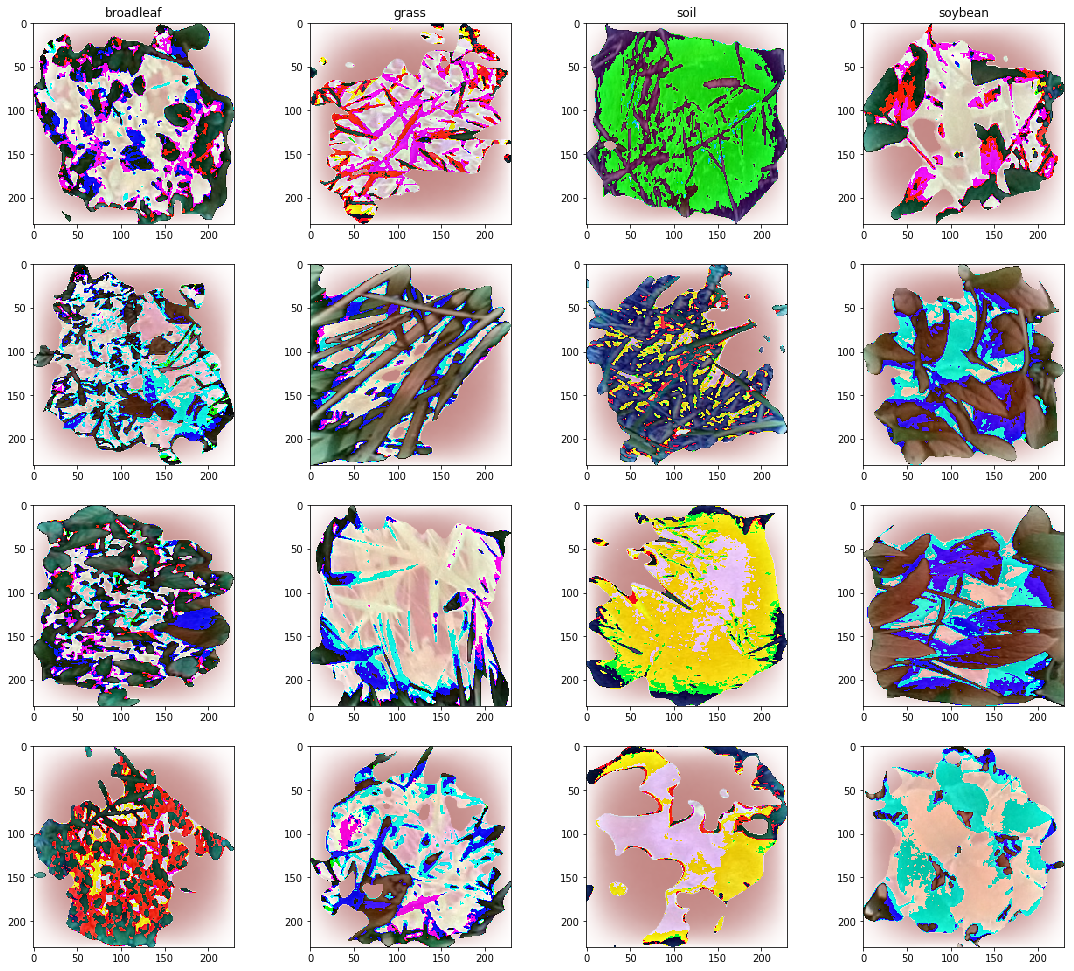

In [16]:
# Visualize some images 
# Make sure that everything when OK
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4


for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx][:-1].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

## Apply Logistic regression Model on Data 


### First: Define 2 Loss function that can possibly apply on Logit regression 
- Softmax loss 
- Loglikely hood loss

##### two Activation function that will be test on
- RELU
- Sigmoid

In [17]:
act = {'relu': lambda x: np.maximum(0,x), 'sigmoid': lambda x:1.0/(1.0 + np.exp(-x))}

def LLloss(X, W, y, reg = 0.0):# Log likelyhood loss
    '''
    X: nd array shape(NxD)
    W: nd array shape(DxC)
    y: nd array shape(NxC) #one hot coded
    https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
    '''
    #convert y_batch to one hot coded
    num_classes = W.shape[1]
    num_train = X.shape[0]
    y_hot = np.zeros((num_train, num_classes))
    y_hot[np.arange(num_train), y.astype(int)] = 1.0 
    
    grad = np.zeros(W.shape)
    scores = act['sigmoid'](np.dot(X, W)) #shape:(NxC)
    error = scores - y_hot
    grad = np.dot(X.T, error)
    loss = 0.0
    
    #zeros out correct class score
    scores[np.arange(num_train),y.astype(int)] = 0 
    loss = np.sum(scores)/num_train
    loss += reg * np.sum(W * W)
    grad += reg * W
    return loss, grad

'''
#Tested model on soft max with result.
'''
def softmax(X, W, y, reg=0.0):
    num_classes = W.shape[1]
    num_train, dim = X.shape
    loss = 0.0 
    dW = np.zeros(W.shape)
    
    scores = act['relu'](X.dot(W)) #Shape: (N x C) 
    
    
    #normalize trick to avoid over flow when compute exp 
    scores -= scores.max(axis=1).reshape(scores.shape[0],1)
    
    correct_score = scores[np.arange(num_train), y]
    
    scores = np.exp(scores)
    
    
    
    scores_sumexp = np.sum(scores, axis=1) #stack vertically
    
    loss = (-1.0) * np.sum(np.log(np.exp(correct_score)/scores_sumexp))
    #Normalize each score with all class score 
    scores /= scores_sumexp.reshape(num_train, 1) #turn (num_train,) -> (num_train, 1) shape
    #turn correct score to (sumexp - S)/sumexp 
    scores[np.arange(num_train), y] = (-1.0) * (scores_sumexp - np.exp(correct_score))/scores_sumexp

    dW = X.T.dot(scores)
    #normalize and add regularization term
    loss /= num_train
    dW /= num_train
    
    loss += reg * np.sum(W * W)
    dW += reg * W
    
    return loss, dW


class LogitRegression(): 
    def __init__(self, lossFunction, activation='sidmoid'): 
        '''
        lossFunction: function pointer
        self.W = assume that the bias is stacked 
        '''
        self.W = None
        self.lossf = lossFunction
        if(activation not in act): print('invalid actiavtion function')
        self.act = act[activation]
    def predict(self, x): 
        if(self.W is None): print('get that weight init')
        scores = self.act(np.dot(x, self.W)) #Score shape: (N x C)
        y_pred = np.argmax(scores, axis=1) #stack verticlly
        return y_pred
    def train(self, X, y, X_val, y_val, iter_num = 100, batch_size = 200, 
                    learn_rate = 1, reg = 0.0, it_verbose = 100, verbose = False):
        '''
        X: nd array shape(N x D) 
        self.W: nd array shape(D x C) 
        '''
        num_train, dim = X.shape
        num_classes = int(np.max(y) + 1) 
        if(self.W is None): 
            self.W = 0.01 * np.random.rand(dim, num_classes) 
            
        # Use SGD to optimize hyperparameter
        loss_hist = [] 
        train_acc_hist = []
        val_acc_hist = [] 
        
        iter_per_epoch = max(num_train/batch_size, 1) 
        
        for it in range(iter_num): 
            #Sampling and split trainning into small batch 
            sampling_idxs = np.random.choice(np.arange(num_train), 
                                    batch_size, replace=False)
            X_batch = X[sampling_idxs]#shape (batch_size x dim)
            y_batch = y[sampling_idxs]#shape (batch_size x 1)
            
            # compute loss and grad using mini batch
            loss, grad = self.lossf(X_batch, self.W, y_batch, reg)
            loss_hist.append(loss)
            
            # update rule 
            self.W += (-1.0) * learn_rate * grad 
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, iter_num, loss)) 
                
            #Every epoch check accuracy of the model 
            if(it%iter_per_epoch==0):#finish one time model read through all datas 
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)
        return {
            'loss_hist': loss_hist, 
            'train_acc_hist': train_acc_hist,
            'val_acc_hist' : val_acc_hist
        }
            

# Debug model with Dev set
## Loglikelyhood loss 

In [18]:
LRlikely = LogitRegression(LLloss, activation='sigmoid')
stats = LRlikely.train(X_train, y_train, X_val, y_val, iter_num = 1000, batch_size = 100, 
                    learn_rate = 1e-7, reg = 1e-3, it_verbose = 100, verbose = True)

# LRsoftmax = LogisticRegression(softmax)
# loss_hist_softmax = LRsoftmax.train(x_dev, y_dev, iter_num=1000, it_verbose=100)

iteration: 0 / 1000 | Loss: 1.671158
iteration: 100 / 1000 | Loss: 0.976903
iteration: 200 / 1000 | Loss: 0.907810
iteration: 300 / 1000 | Loss: 0.745883
iteration: 400 / 1000 | Loss: 0.697703
iteration: 500 / 1000 | Loss: 0.666866
iteration: 600 / 1000 | Loss: 0.698121
iteration: 700 / 1000 | Loss: 0.580224
iteration: 800 / 1000 | Loss: 0.626330
iteration: 900 / 1000 | Loss: 0.575171


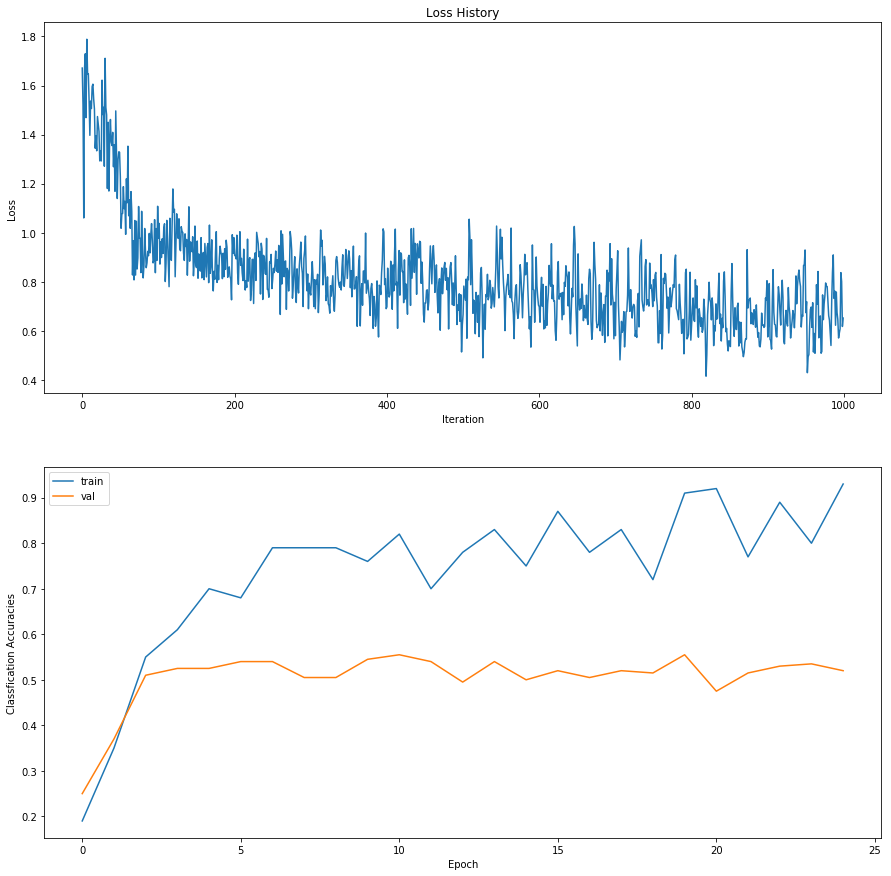

In [19]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats['train_acc_hist'], label='train')
plt.plot(stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

### Hyperparameter tuning using crosvalidation 

In [20]:
learning_rates = [ 0.55]

#Note: higher regularization term
regularization_strength = [0.075] 
best_val = 0.0 
best_LLmodel = None
best_stats = None
result = {}

'''Good search on hyperparameter
learn: 3.6e-05 r: 1 train_acc 0.635 val_acc 0.48 test_acc 0.58
learn: 3.5e-06 r: 0.1 train_acc 0.54 val_acc 0.48 test_acc 0.58
learn: 3.6e-05 r: 0.01 train_acc 0.57 val_acc 0.475 test_acc 0.595
learn: 0.55 r: 0.075 train_acc 0.595 val_acc 0.45 test_acc 0.595
'''

for learn in learning_rates:
    for r in regularization_strength: 
        tune_model = LogitRegression(LLloss, activation='sigmoid')
        stats_tune = tune_model.train(X_train, y_train, X_val, y_val, iter_num = 150, batch_size = 500, 
                    learn_rate = 1e-7, reg = 1e-3, it_verbose = 100, verbose = False)
        
        train_acc = stats_tune['train_acc_hist'][-1]
        val_acc = stats_tune['val_acc_hist'][-1]
        test_acc = (tune_model.predict(X_test) == y_test).mean()
        result[(train_acc, val_acc, test_acc)] = (learn, r) 
        #print log 
        print('learn:',learn,'r:',r,'train_acc',train_acc,'val_acc',val_acc,'test_acc', test_acc)
        if(test_acc > best_val):
            best_val = test_acc 
            best_LLmodel = tune_model
            best_stats = stats_tune
        del tune_model 


learn: 0.55 r: 0.075 train_acc 0.57 val_acc 0.46 test_acc 0.51


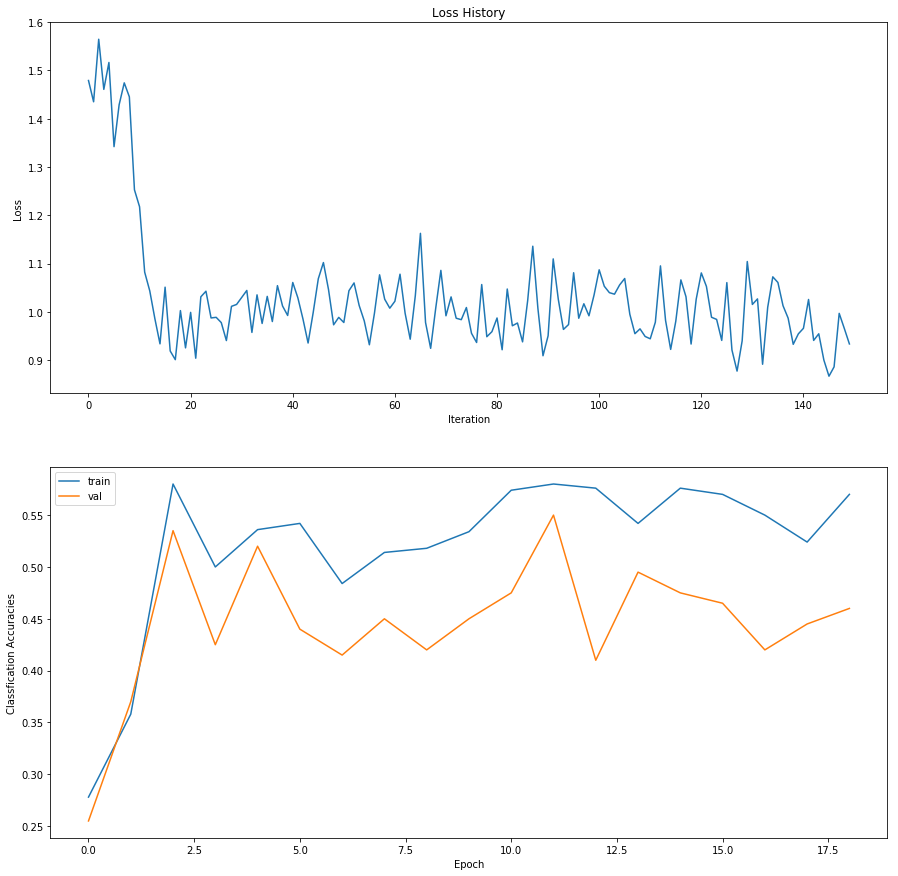

In [21]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(best_stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(best_stats['train_acc_hist'], label='train')
plt.plot(best_stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

## Softmax loss with relu 

In [22]:
LRsoftmax = LogitRegression(softmax, activation='relu')
stats_softmax = LRsoftmax.train(X_train, y_train.astype(int), X_val, y_val.astype(int), iter_num = 10, batch_size = 10, 
                    learn_rate =1e-7, reg =0.0, it_verbose = 1, verbose = True)

iteration: 0 / 10 | Loss: 42.973389
iteration: 1 / 10 | Loss: 25.489170
iteration: 2 / 10 | Loss: 64.554598
iteration: 3 / 10 | Loss: 45.511037
iteration: 4 / 10 | Loss: 19.334530
iteration: 5 / 10 | Loss: 46.957623
iteration: 6 / 10 | Loss: 29.900162
iteration: 7 / 10 | Loss: 29.894417
iteration: 8 / 10 | Loss: 5.421119
iteration: 9 / 10 | Loss: 38.994791


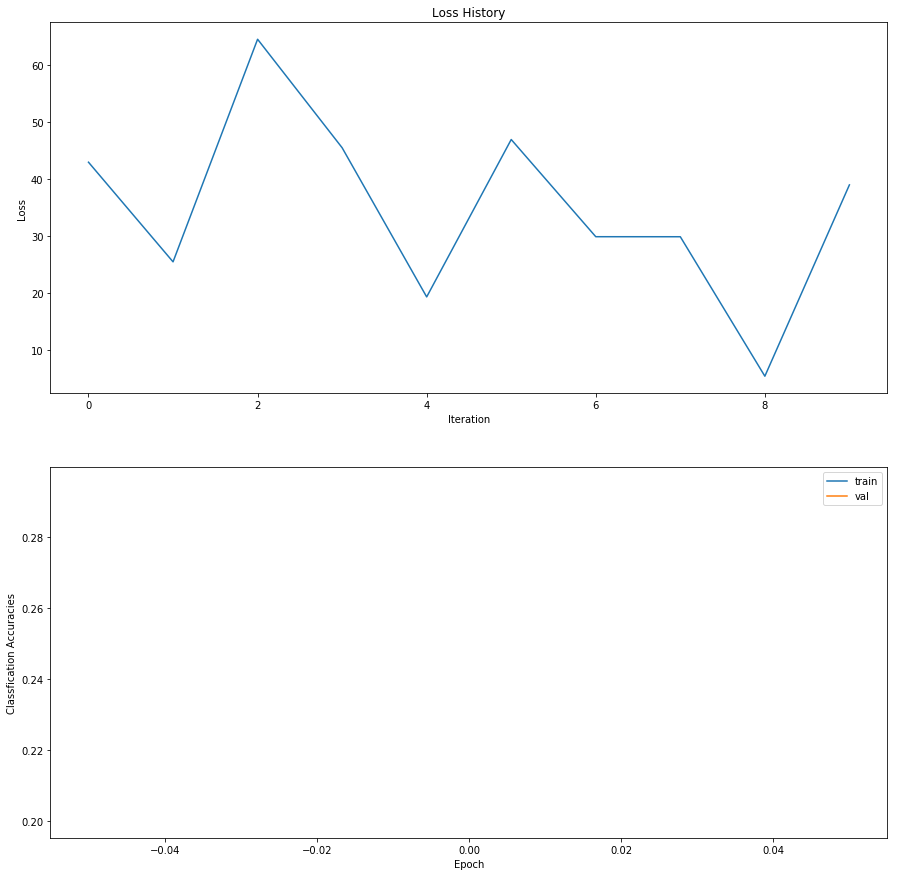

In [23]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(stats_softmax['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats_softmax['train_acc_hist'], label='train')
plt.plot(stats_softmax['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend() 
plt.show()


[ 2.9969250e+01 -2.2777500e+00  5.3827750e+01  3.1108500e+01
  3.8707500e+00  5.5914250e+01  3.5164750e+01 -2.1235000e+00
  4.9900750e+01  2.8112000e+01 -2.3233750e+01  2.6685000e+01
  6.7822500e+00 -3.7236250e+01  1.3701250e+01 -7.2420000e+00
 -2.5291250e+01  2.7746750e+01  6.7595000e+00 -1.3359000e+01
  4.1795500e+01  2.0727250e+01 -1.4381250e+01  4.3898250e+01
  2.1759000e+01 -1.5299500e+01  4.4101000e+01  2.1913250e+01
 -9.9515000e+00  5.1549500e+01  2.9357750e+01 -9.9120000e+00
  5.2714250e+01  3.0534500e+01 -1.4978000e+01  4.9613750e+01
  2.6482250e+01 -2.2768750e+01  4.4833250e+01  2.1661250e+01
 -1.8783000e+01  4.8873500e+01  2.5652500e+01 -7.9660000e+00
  5.7783750e+01  3.4585750e+01 -4.0652500e+00  5.6677250e+01
  3.4524250e+01  3.9330000e+00  5.9687000e+01  3.7468750e+01
  1.7099500e+01  6.9972250e+01  4.7684500e+01  2.8081750e+01
  7.9231500e+01  5.7858750e+01  3.3019250e+01  8.3413500e+01
  6.2034250e+01  2.9140250e+01  8.1942750e+01  6.1517250e+01
  3.1583750e+01  8.55755

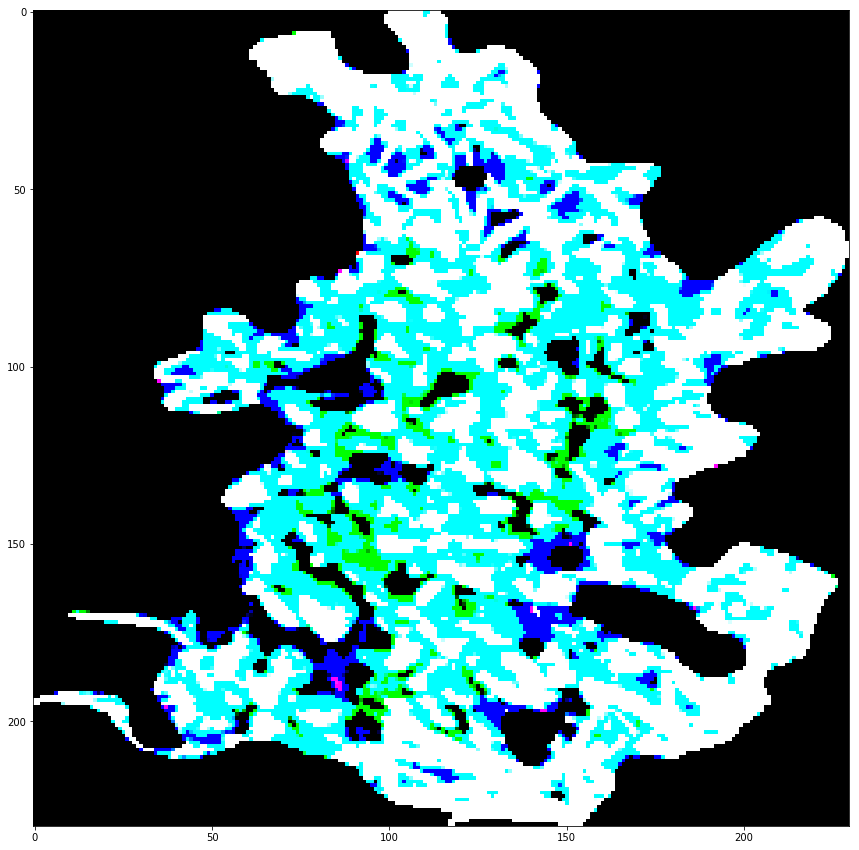

In [24]:
# print(LRsoftmax.W[158700])
# Image dimension
im_width = 230
im_height = 230 
im_channel = 3
dim = im_width * im_height * im_channel
plt.imshow(X_val[2][:-1].reshape(im_width, im_height, im_channel))

print(X_val[2][:-1][128000:129000])